In [1]:
import jax
from functools import partial
from jax import grad, jacfwd, vmap, jit, hessian, value_and_grad
from jax.lax import scan
# from jax.ops import index_update, index
import jax.random as jnp_random
import jax.numpy as np

from jax.flatten_util import ravel_pytree

import numpy as onp
from time_opt_erg_lib.dynamics import DoubleIntegrator, SingleIntegrator

from time_opt_erg_lib.ergodic_metric import ErgodicMetric
from time_opt_erg_lib.obstacle import Obstacle
from time_opt_erg_lib.cbf import constr2CBF
from time_opt_erg_lib.fourier_utils import BasisFunc, get_phik, get_ck
from time_opt_erg_lib.target_distribution import TargetDistribution
from time_opt_erg_lib.cbf_utils import sdf2cbf
from IPython.display import clear_output
import matplotlib.pyplot as plt

from time_opt_erg_lib.opt_solver import AugmentedLagrangeSolver
import yaml
import pickle as pkl


In [4]:
args = {
    'N' : 200, 
    'x0' : np.array([0.5, 0.1]),
    'xf' : np.array([2.0, 3.2]),
    'erg_ub' : 0.01,
    'alpha' : 0.2,
    'wrksp_bnds' : np.array([[0.,3.5],[-1.,3.5]])
}

basis           = BasisFunc(n_basis=[8,8])
erg_metric      = ErgodicMetric(basis)
robot_model     = SingleIntegrator()
n,m = robot_model.n, robot_model.m
target_distr    = TargetDistribution()
workspace_bnds = args['wrksp_bnds']

args.update({
    'phik' : get_phik(target_distr.evals, basis),
})


with open('cluttered_env_v2.yml', 'r') as file:
    obs_info = yaml.safe_load(file)

obs = []
cbf_constr = []
for _ob_inf in obs_info['obstacles']:
    _ob = Obstacle(_ob_inf)
        # pos=np.array(obs_info[obs_name]['pos']), 
        # half_dims=np.array(obs_info[obs_name]['half_dims']),
        # th=obs_info[obs_name]['rot']
    obs.append(_ob)
    cbf_constr.append(sdf2cbf(robot_model.dfdt, _ob.distance))

    


@vmap
def emap(x):
    """ Function that maps states to workspace """
    return np.array([
        (x[0]-workspace_bnds[0][0])/(workspace_bnds[0][1]-workspace_bnds[0][0]), 
        (x[1]-workspace_bnds[1][0])/(workspace_bnds[1][1]-workspace_bnds[1][0])])
        
def barrier_cost(e):
    """ Barrier function to avoid robot going out of workspace """
    return (np.maximum(0, e-1) + np.maximum(0, -e))**2

# @jit
def loss(params, args):
    x = params['x']
    u = params['u']
    tf = params['tf']
    N = args['N']
    dt = tf/N
    e = emap(x)
    """ Traj opt loss function, not the same as erg metric """
    return np.sum(barrier_cost(e)) + tf

def eq_constr(params, args):
    """ dynamic equality constriants """
    x = params['x']
    u = params['u']

    x0 = args['x0']
    xf = args['xf']
    tf = params['tf']
    N = args['N']
    dt = tf/N
    return np.vstack([
        x[0] - x0, 
        x[1:,:]-(x[:-1,:]+dt*vmap(robot_model.dfdt)(x[:-1,:], u[:-1,:])),
        x[-1] - xf
    ])

def ineq_constr(params, args):
    """ inequality constraints"""
    x = params['x']
    u = params['u']
    phik = args['phik']
    tf = params['tf']
    N = args['N']
    dt = tf/N
    e = emap(x)
    _cbf_ineq = [vmap(_cbf_ineq, in_axes=(0,0,None, None))(x, u, args['alpha'], dt).flatten() 
                for _cbf_ineq in cbf_constr]
    ck = get_ck(e, basis, tf, dt)
    _erg_ineq = [np.array([erg_metric(ck, phik) - args['erg_ub'], -tf])]
    _ctrl_box = [(np.abs(u) - 6.).flatten()]
    return np.concatenate(_erg_ineq + _ctrl_box + _cbf_ineq)
    # return np.array([erg_metric(ck, phik) - 0.001, -tf] + [(np.abs(u) - 2.).flatten()])
    # return np.array(0.)
    # p = x[:,:2] # extract just the position component of the trajectory
    # # obs_val = [vmap(_ob.distance)(p).flatten() for _ob in self.obs]
    # obs_val = [vmap(_cbf_ineq)(x, u).flatten() for _cbf_ineq in self.cbf_consts]
    # ctrl_box = [(np.abs(u) - 2.).flatten()]
    # _ineq_list = ctrl_box + obs_val
    # return np.array(0.)


In [5]:
x = np.linspace(args['x0'], args['xf'], args['N'], endpoint=True)
u = np.zeros((args['N'], robot_model.m))
init_sol = {'x': x, 'u' : u, 'tf': np.array(10.0)}

In [6]:
solver = AugmentedLagrangeSolver(
                init_sol,
                loss, 
                eq_constr, 
                ineq_constr, 
                args, 
                step_size=0.0005,
                c=1.0)

In [7]:
solver.solve(max_iter=10000, eps=1e-7)
sol = solver.get_solution()


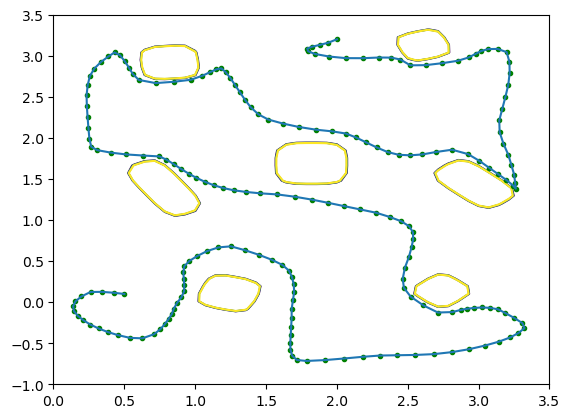

In [8]:
X, Y = np.meshgrid(*[np.linspace(wks[0],wks[1]) for wks in args['wrksp_bnds']])
pnts = np.vstack([X.ravel(), Y.ravel()]).T

_mixed_vals = np.inf * np.ones_like(X)
for ob in obs:
    _vals = np.array([ob.distance(pnt) for pnt in pnts]).reshape(X.shape)
    _mixed_vals = np.minimum(_vals, _mixed_vals)

    plt.contour(X, Y, _vals.reshape(X.shape), levels=[-0.01,0.,0.01])

plt.plot(sol['x'][:,0], sol['x'][:,1],'g.')
plt.plot(sol['x'][:,0], sol['x'][:,1])


plt.show()

In [21]:
sol.update({
    'x': np.array(sol['x']),
    'u' : np.array(sol['u']),
    'tf': np.array(sol['tf'])
})

_file = open('test_traj_max_erg.pkl', 'wb')
pkl.dump(sol, _file)

(Array(8.801584, dtype=float32, weak_type=True),
 Array([-0.02973067, -8.801584  ], dtype=float32))